In [2]:
from bnt_smooth import ProcessMaps
from bnt_smooth import NzEuclid
import numpy as np
import pyccl as ccl 

In [3]:
z = np.linspace(0.01, 2.5, 500)
nside = 1500
l_max = 512
nslices = 15
nbins = 5
n_eff_list = [30.0 / nbins] * nbins
sigma_eps_list = [0.26] * nbins
baryon_feedback = 7.
seed = 1234
alpha = 1.
beta = 1.



In [4]:
Nz = NzEuclid(nbins = nbins, z=z)
nz_list = Nz.get_nz()

In [5]:
sim = ProcessMaps(
    z_array=z,
    nz_list=nz_list,
    n_eff_list=n_eff_list,
    sigma_eps_list=sigma_eps_list,
    baryon_feedback=baryon_feedback,
    alpha=alpha,
    beta=beta,
    seed=np.random.randint(1e6),
    l_max=l_max,
    nside=nside,
    nslices=nslices
)
sim.set_cosmo()

0.0

# kernel plot

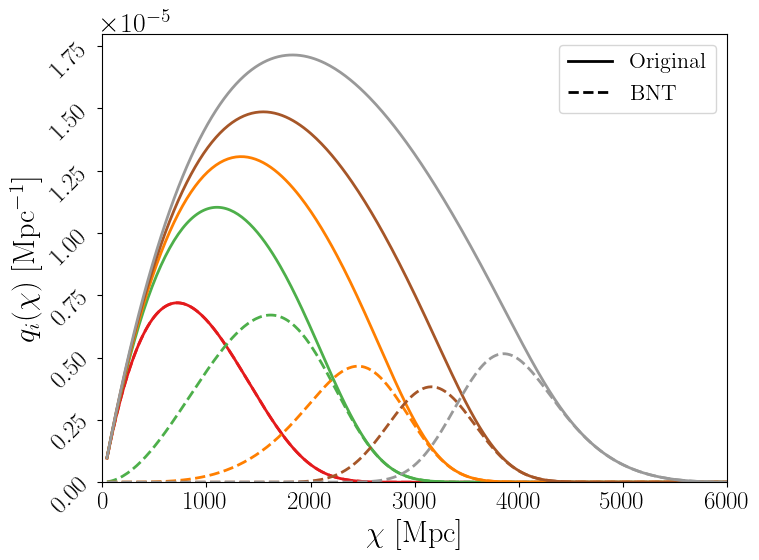

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=20)

# --- Get chi and q(chi) for all source bins ---
chi, q_list = sim.get_lensing_kernels_on_z_grid()
q_bnt_list = sim.bnt_transform_lensing_kernels()

# --- Plot ---
plt.figure(figsize=(8, 6))

colors = plt.get_cmap('Set1')(np.linspace(0, 1, len(q_list)))

for i, (q, q_bnt) in enumerate(zip(q_list, q_bnt_list)):
    plt.plot(chi, q, linestyle='-', linewidth=2, color=colors[i])
    plt.plot(chi, q_bnt, linestyle='--', linewidth=2, color=colors[i])

# Custom legend entries (black solid and dashed lines only)
legend_elements = [
    Line2D([0], [0], color='black', lw=2, linestyle='-', label='Original'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', label='BNT')
]
plt.legend(handles=legend_elements, fontsize=16)

plt.xlabel(r'$\chi\ \mathrm{[Mpc]}$', fontsize=22)
plt.ylabel(r'$q_i(\chi)\ \mathrm{[Mpc^{-1}]}$', fontsize=22)
plt.xlim(0, 6000)
plt.ylim(bottom=0)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.yticks(rotation=45)
plt.tight_layout()
plt.savefig("plots/kernels.pdf")
plt.show()

In [7]:
sim.get_bnt_matrix()

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-1.        ,  1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.27009163, -1.27009163,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.65785846, -1.65785846,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.9734639 , -1.9734639 ,  1.        ]])

In [8]:
sim_strong_baryon = ProcessMaps(
    z_array=z,
    nz_list=nz_list,
    n_eff_list=n_eff_list,
    sigma_eps_list=sigma_eps_list,
    baryon_feedback=10.,
    alpha=alpha,
    beta=beta,
    seed=np.random.randint(1e6),
    l_max=l_max,
    nside=nside,
    nslices=nslices
)
sim_strong_baryon.set_cosmo()


sim_no_baryon = ProcessMaps(
    z_array=z,
    nz_list=nz_list,
    n_eff_list=n_eff_list,
    sigma_eps_list=sigma_eps_list,
    baryon_feedback=0.,
    alpha=alpha,
    beta=beta,
    seed=np.random.randint(1e6),
    l_max=l_max,
    nside=nside,
    nslices=nslices
)
sim_no_baryon.set_cosmo()

0.0

# baryon plot

/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_13237/2519610802.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues_r')


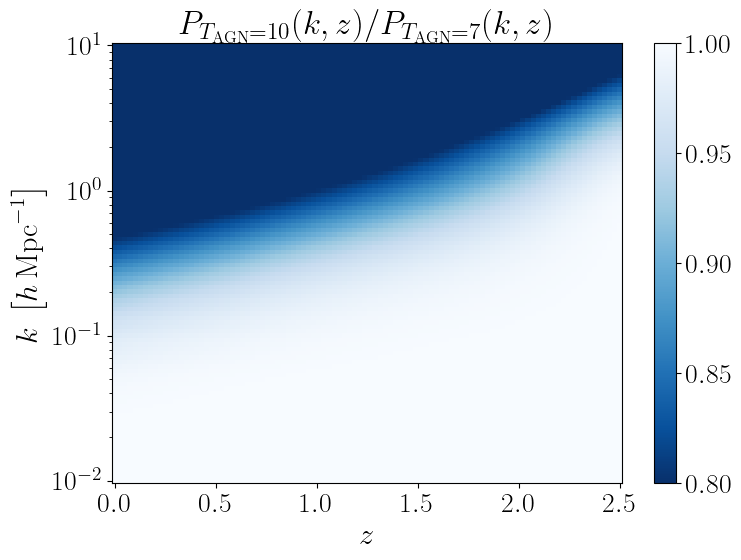

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

# Define k and z ranges
k = np.logspace(np.log10(0.01), np.log10(10.0), 100)
z = np.linspace(0, 2.5, 100)
a = 1.0 / (1.0 + z)

# Compute power spectra
p_strong = np.array([[ccl.nonlin_matter_power(sim_strong_baryon.cosmo, k=ki, a=ai) for ai in a] for ki in k])
p_weak = np.array([[ccl.nonlin_matter_power(sim.cosmo, k=ki, a=ai) for ai in a] for ki in k])

# Compute ratio
ratio = p_strong / p_weak

# Define normalization centered at 1
norm = Normalize(vmin=0.8, vmax=1.0)

# Use a reversed blue colormap (light to dark)
cmap = cm.get_cmap('Blues_r')

# Plot
plt.figure(figsize=(8, 6))
im = plt.pcolormesh(z, k, ratio, shading='auto', cmap=cmap, norm=norm)
plt.yscale('log')
plt.xlabel(r'$z$', fontsize=22)
plt.ylabel(r'$k\;\left[h\,\mathrm{Mpc}^{-1}\right]$', fontsize=22)
plt.title('$P_{T_\mathrm{AGN} = 10} (k,z) / P_{T_\mathrm{AGN} = 7} (k,z) $')
plt.colorbar(im)
plt.tight_layout()
plt.savefig("plots/baryons.png")
plt.show()

# Fisher plot

# field plots

In [12]:
maps = sim.generate_gauss_matter_fields_from_scratch()
delta_maps = sim.make_skewed_delta_maps(maps)
kappa_maps = sim.compute_kappa_maps(delta_map)

NameError: name 'delta_map' is not defined

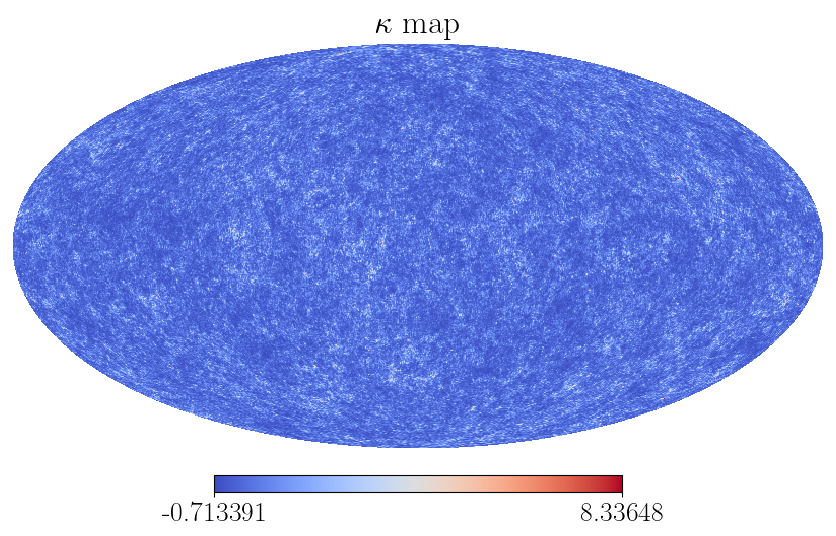

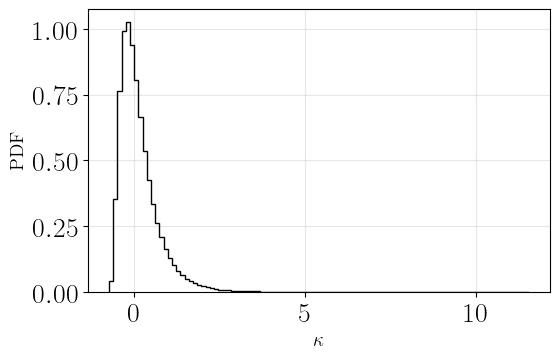

In [10]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt


kappa_map = maps[0]

# --- Plot the map ---
hp.mollview(kappa_map, title=r'$\kappa$ map', cmap='coolwarm')
plt.show()

# --- Compute 1-point PDF ---
plt.figure(figsize=(6, 4))
plt.hist(kappa_map, bins=100, density=True, histtype='step', color='black')
plt.xlabel(r'$\kappa$', fontsize=14)
plt.ylabel(r'PDF', fontsize=14)
#plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()